<a href="https://colab.research.google.com/github/bc0403/emg/blob/main/semg_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
# prerequisites
import os
import urllib.request
import zipfile
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
from scipy.fftpack import fft, ifft
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

font = {
        'size'   : 16}

matplotlib.rc('font', **font)

In [60]:
# retrieve data
url = "https://calffrog.com/data/semg.zip"
file_name = "semg.zip"

if os.path.isfile(file_name):
    print("\nFile already exists.")
else:
    print("\nDownloading file...")
    urllib.request.urlretrieve(url, file_name)
    print("\nDownloaded.")
    print("\nUnzipping file...")
    zip_ref = zipfile.ZipFile(file_name, 'r')
    zip_ref.extractall("./")
    zip_ref.close()
    print("\nUnzipped.")
print(os.listdir())



File already exists.
['.config', 'semg.zip', 'semg.csv', 'sample_data']


本示例文件的硬件采集系统主要指标如下：
* sample rate: 1000 Hz
* channel number: 32
* used channels: channel 1 and channel 2
* record time: around 230 s

以下分析 channel 1 的数据。

**读入原始数据**

In [61]:
# read data
totalChannel = 32
DEBUG = True
sample_rate = 1000  # Hz

col_names = [] # coloumn names of a dataframe
for i in range(totalChannel):
    col_names.append("ch" + str(i+1))
if DEBUG:
    print(col_names)

datafile = "semg.csv"
df = pd.read_csv(datafile, sep='\s+', names=col_names)
df = df.drop([0])  # drop row 0, which includes an outlier
print(df.head())
print(df.describe())


['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8', 'ch9', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch16', 'ch17', 'ch18', 'ch19', 'ch20', 'ch21', 'ch22', 'ch23', 'ch24', 'ch25', 'ch26', 'ch27', 'ch28', 'ch29', 'ch30', 'ch31', 'ch32']
       ch1      ch2       ch3  ...       ch30      ch31       ch32
1 -3669.92  6558.00  187367.0  ...  187370.04  187368.0  187366.92
2 -3669.63  6557.13  187367.0  ...  187370.04  187368.0  187366.92
3 -3668.63  6557.04  187367.0  ...  187370.04  187368.0  187366.92
4 -3669.13  6556.96  187367.0  ...  187370.04  187368.0  187366.92
5 -3669.67  6557.38  187367.0  ...  187370.04  187368.0  187366.92

[5 rows x 32 columns]
                 ch1            ch2  ...      ch31           ch32
count  231912.000000  231912.000000  ...  231912.0  231912.000000
mean    -1755.719158    7932.775505  ...  187368.0  187366.919999
std       913.824617     638.064355  ...       0.0       0.000001
min     -3670.210000    6410.670000  ...  187368.0  187366.9200

**Plot 原始数据**

观察时域信号和频域信号

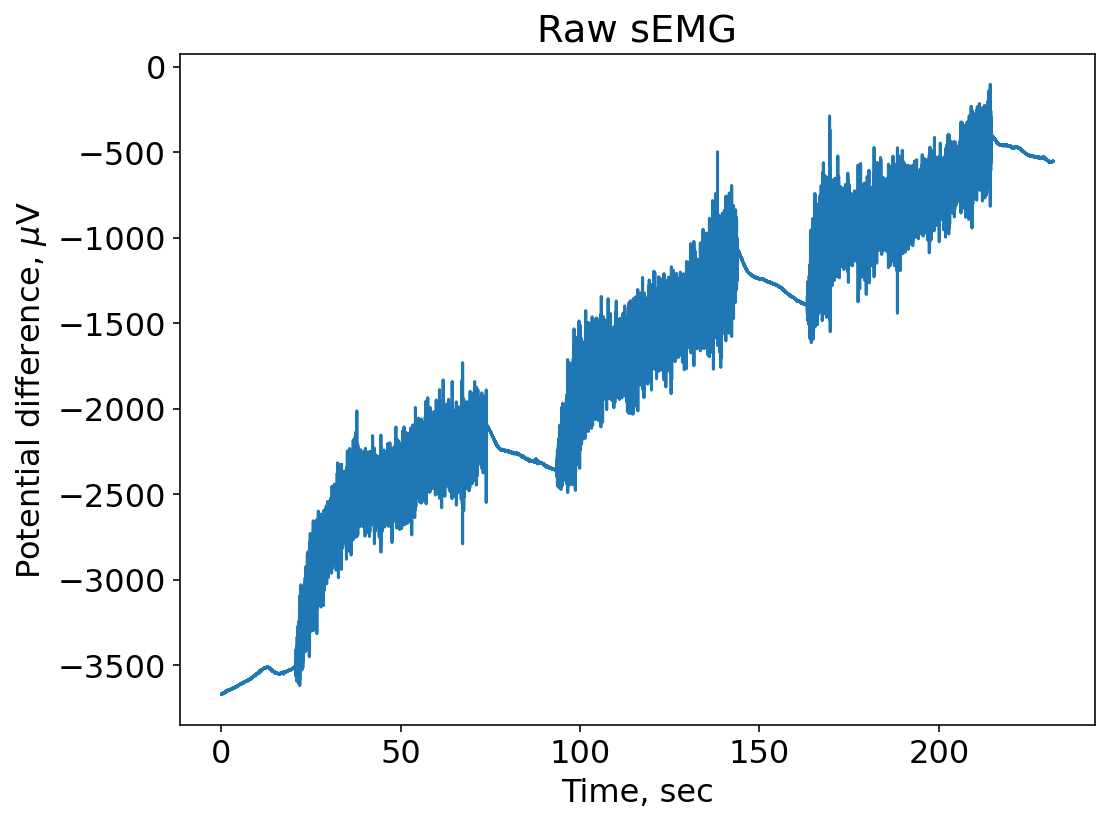

In [62]:
# raw data
df1_raw = df["ch1"]  # channel 1 and channel 2 have raw sEMG data
time = np.array([i/sample_rate for i in range (0, len(df1_raw), 1)])  

# plot the raw data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time, df1_raw)
ax.set_title("Raw sEMG")
ax.set_xlabel('Time, sec')
ax.set_ylabel(r'Potential difference, $\mu$V')
fig.tight_layout()

(0.0, 2.0)

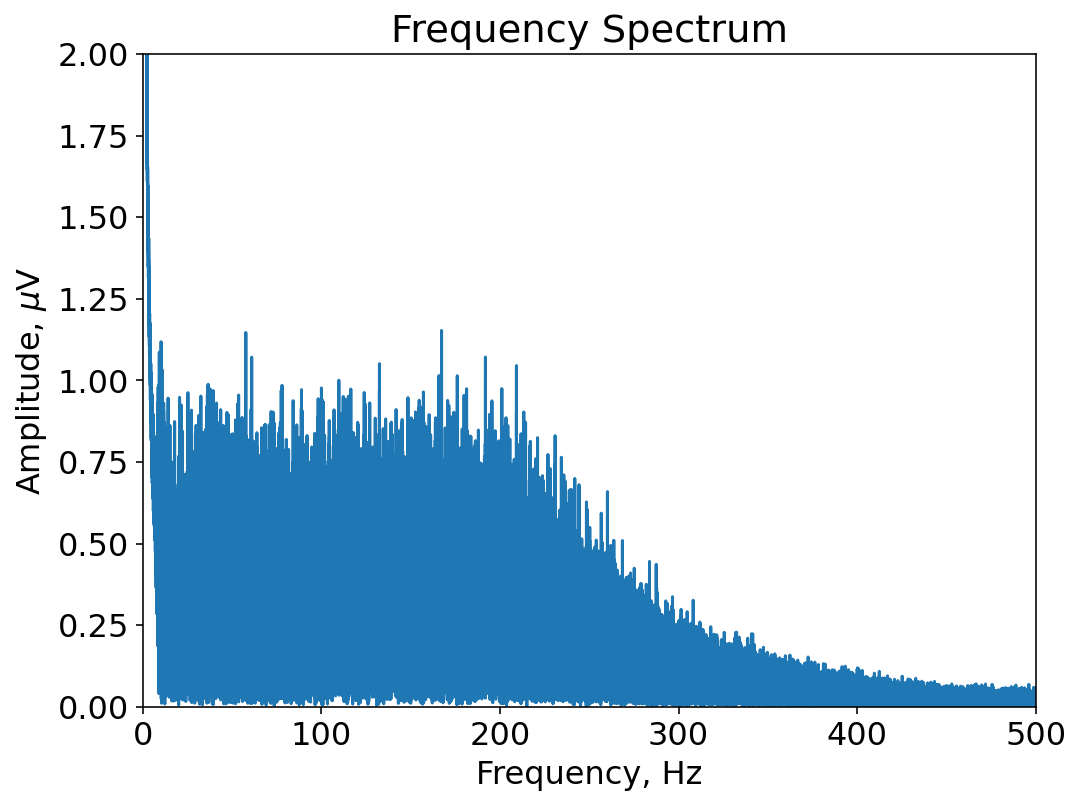

In [63]:
def fft_emg(emg, sample_rate=1000):
    """
    apply fft algorithm to semg signals
    parameters:
    emg: emg signals in time domain
    sample_rate: sample rate, Hz
    returns:
    amp: amplitude spectrum
    freq: frequency axis
    """
    time = np.linspace(0, (len(emg)-1)/sample_rate, len(emg))
    yf = fft(emg, time.size)

    amp = np.abs(yf)
    amp_norm = (2/amp.size)*amp[0:amp.size//2]  # normalize and only return the positive part of amplitude spectrum
    freq = np.linspace(0.0, sample_rate/2.0, time.size//2)

    return (amp_norm, freq)

(amp, freq) = fft_emg(df1_raw.to_numpy())
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(freq, amp)
ax.set_title("Frequency Spectrum")
ax.set_xlabel("Frequency, Hz")
ax.set_ylabel(r"Amplitude, $\mu$V")
ax.set_xlim(0, 500)
ax.set_ylim(0, 2)

**Remove baseline drift**

基线漂移的可能原因：
* 运动伪影（做动作时，电极和肌肉之间有相对运动）
* 界面伪影（电极和皮肤的接触界面的热噪声、电化学噪声引起）
* 内在不稳定性（Motor Unit的内在不稳定引起的）

Ref: https://web.fe.up.pt/~tavares/downloads/publications/relatorios/TP-MiguelCarmo.pdf

基线漂移的修正方法：
* 加高通滤波器，截止频率可选20Hz

同时，sEMG的频率一般小于500Hz（所以一般情况下用1000Hz的采样率就可以了），因此这里我们施加20-450Hz的带通率滤波器，带通滤波器的说明如下：
* Butterworth滤波器具有最大平坦响应，带内失真小
* 4阶Butterworth滤波器
* 采用`scipy.signal.butter`实现

Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html



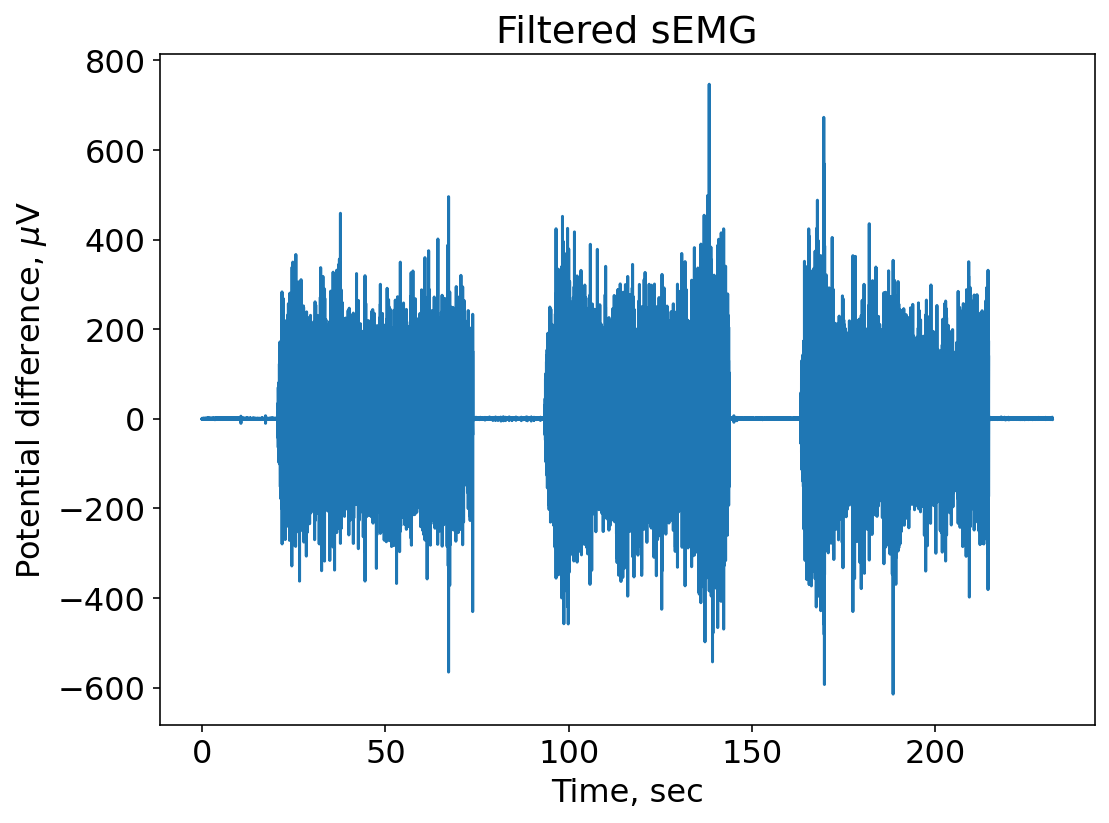

In [64]:
# process 1, remove the baseline drift
def bpf_emg(emg, fL, fH, sample_rate=1000, order=4):
    """
    apply a band pass filter (bpf) to the sEMG signals
    emg: unfiltered emg signals
    fL: low limit of bandpass filter, Hz
    fH: high limit of bandpass filter, Hz
    sample_rate: sample rate of sEMG signals, Hz
    order: the order of Butterworth filter, default is 4th order
    """
    # define a bandpass filter
    high = fL/(sample_rate/2)
    low = fH/(sample_rate/2)
    b, a = sp.signal.butter(order, [high, low], btype='bandpass')

    # filter the sEMG signals
    emg_filtered = sp.signal.filtfilt(b, a, emg)

    return emg_filtered

emg_filtered = bpf_emg(df1_raw.to_numpy(), 20, 450, 1000)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time, emg_filtered)
ax.set_title("Filtered sEMG")
ax.set_xlabel('Time, sec')
ax.set_ylabel(r"Potential difference, $\mu$V")
# ax.set_xlim(0, 5)
fig.tight_layout()

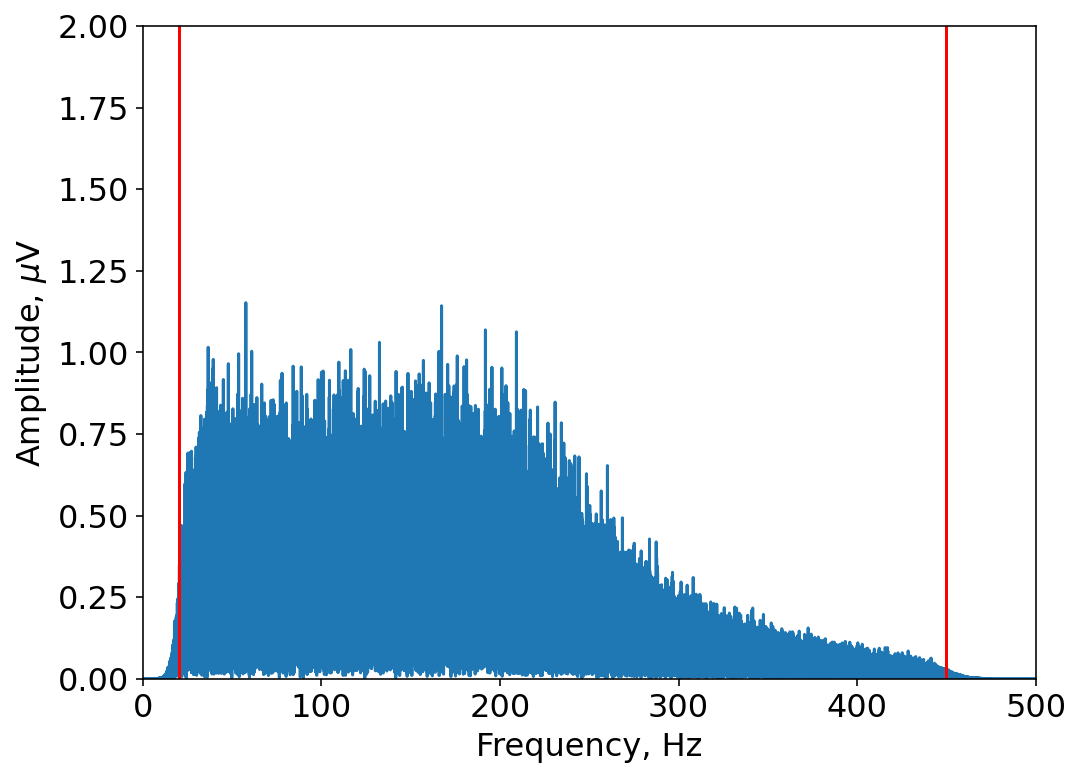

In [65]:
(amp, freq) = fft_emg(emg_filtered)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(freq, amp)
ax.set_xlabel("Frequency, Hz")
ax.set_ylabel(r"Amplitude, $\mu$V")
ax.set_xlim(0, 500)
ax.set_ylim(0, 2)
ax.axvline(20, color='r')
ax.axvline(450, color='r')

**Check baseline quality**

若静息状态时，信号幅度大于2µV，则表明原始信号噪声太大

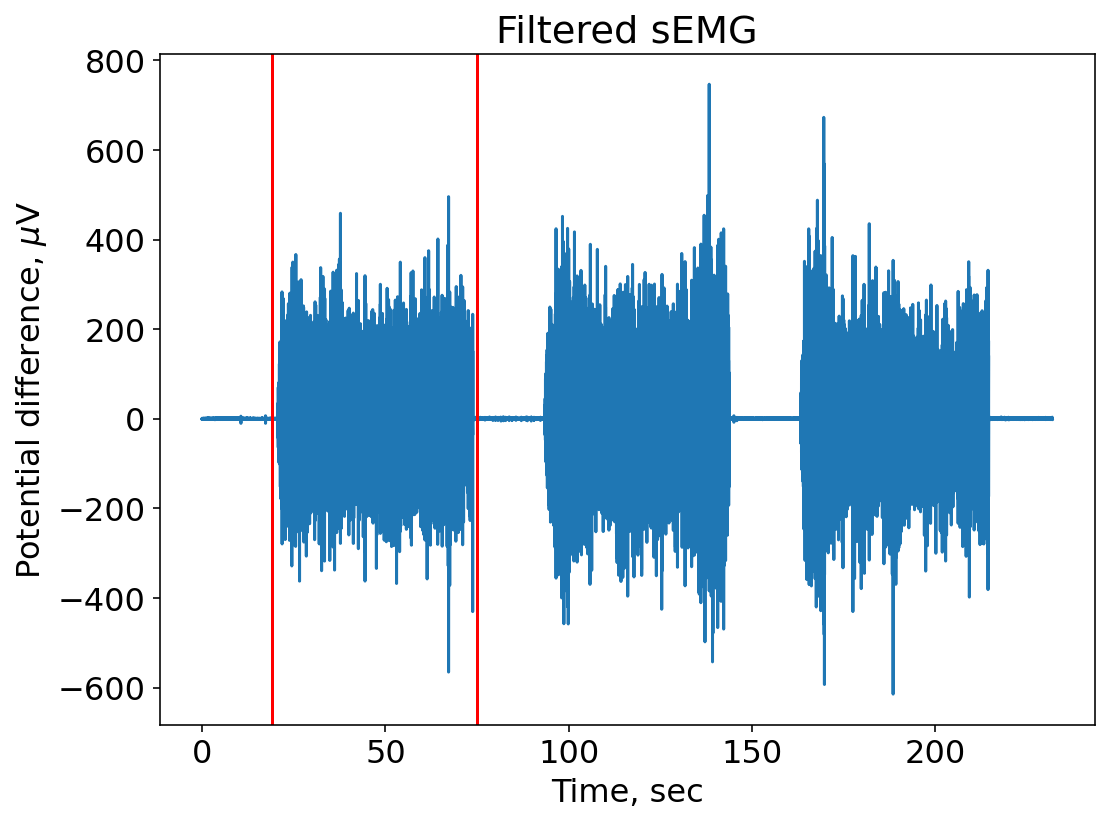

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time, emg_filtered)
ax.set_title("Filtered sEMG")
ax.set_xlabel('Time, sec')
ax.set_ylabel(r"Potential difference, $\mu$V")
ax.axvline(19, color='r')
ax.axvline(75, color='r')
fig.tight_layout()

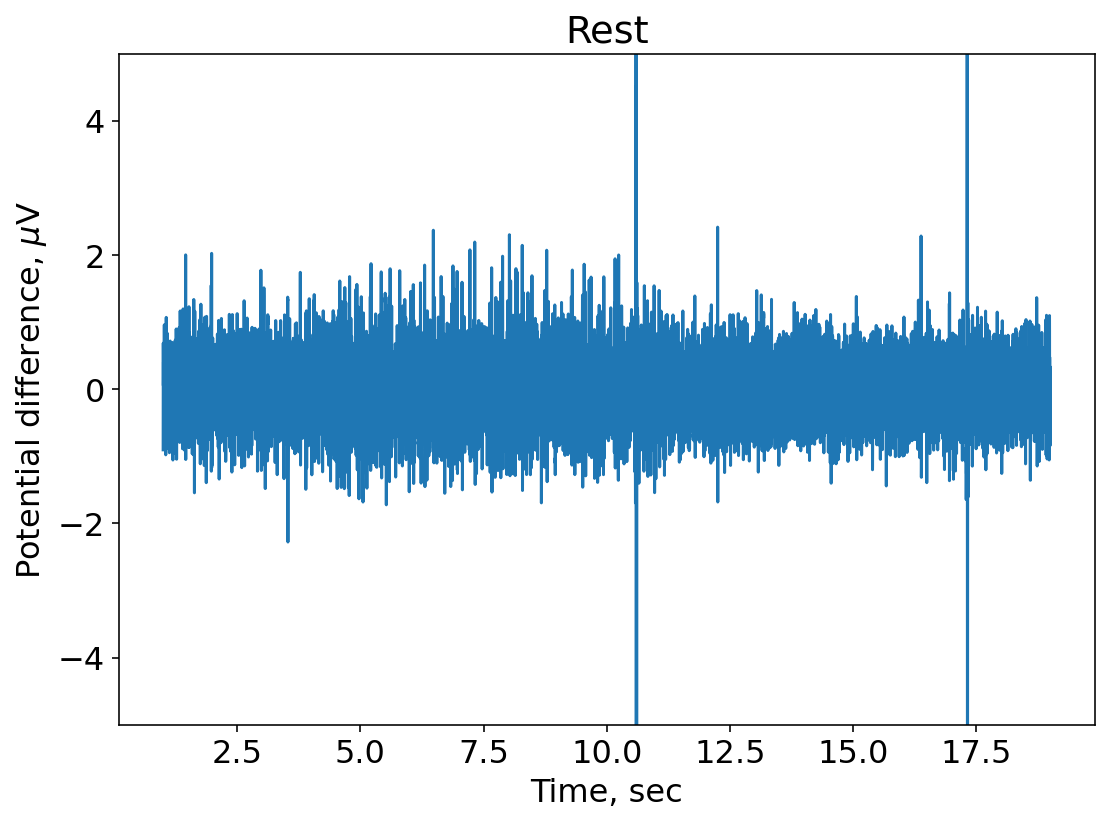

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time[1000:19000], emg_filtered[1000:19000])
# ax.axhline(np.mean(np.abs(emg_filtered[1000:19000])), color='k')
ax.set_title("Rest")
ax.set_xlabel('Time, sec')
ax.set_ylabel(r"Potential difference, $\mu$V")
ax.set_ylim(-5, 5)
fig.tight_layout()

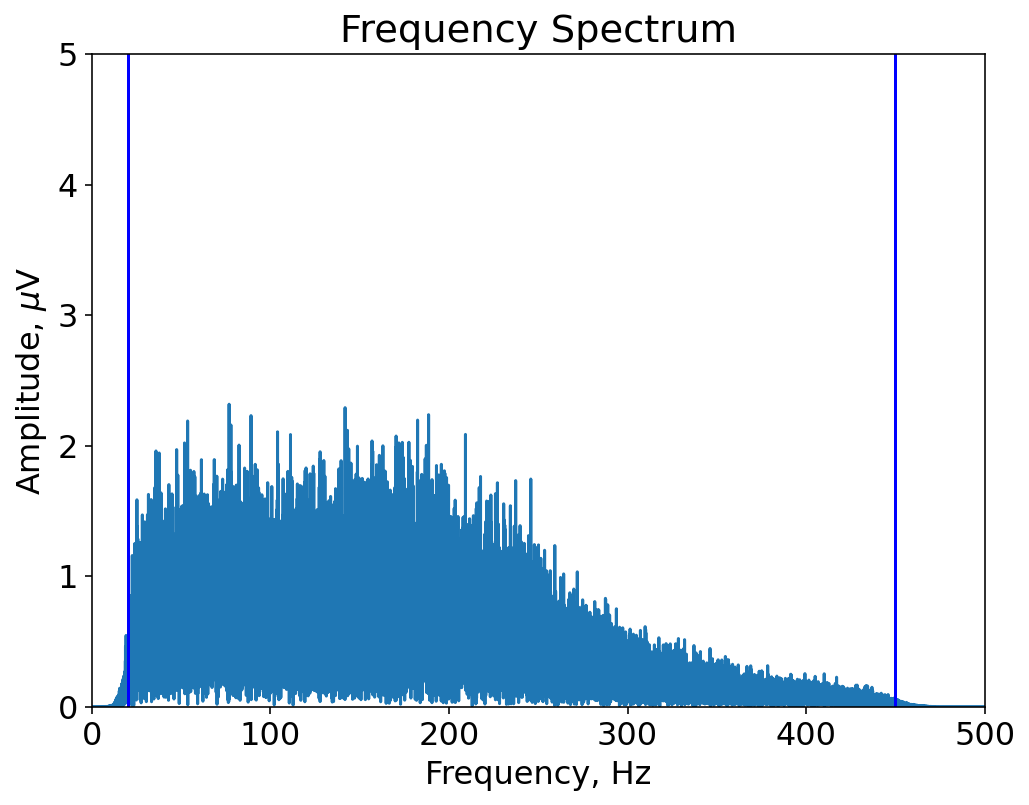

In [68]:
(amp, freq) = fft_emg(emg_filtered[19000:75000])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(freq, amp)
ax.set_title("Frequency Spectrum")
ax.set_xlabel("Frequency, Hz")
ax.set_ylabel(r"Amplitude, $\mu$V")
ax.set_xlim(0, 500)
ax.set_ylim(0, 5)
ax.axvline(20, color='b')
ax.axvline(450, color='b')

**Evaluate the Median Frequency**

Welch window的选择

* window要足够长，至少包含两个最低频率的周期时间；最低频率20Hz，T=50ms，所以window至少100ms
* window值越大，分辨率越高。当window值在100时，频率分辨率为10Hz；1000时，频率分辨率为1Hz


[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [2.60114958e-02 1.29484213e-02 5.05067834e-08 5.91216027e-08
 7.33840771e-08 9.81114050e-08 1.43868075e-07 5.84967960e-07
 5.46027433e-06 5.57939621e-05]

media frequency: 141.0 Hz


Text(200, 0.1, 'MF: 141 Hz')

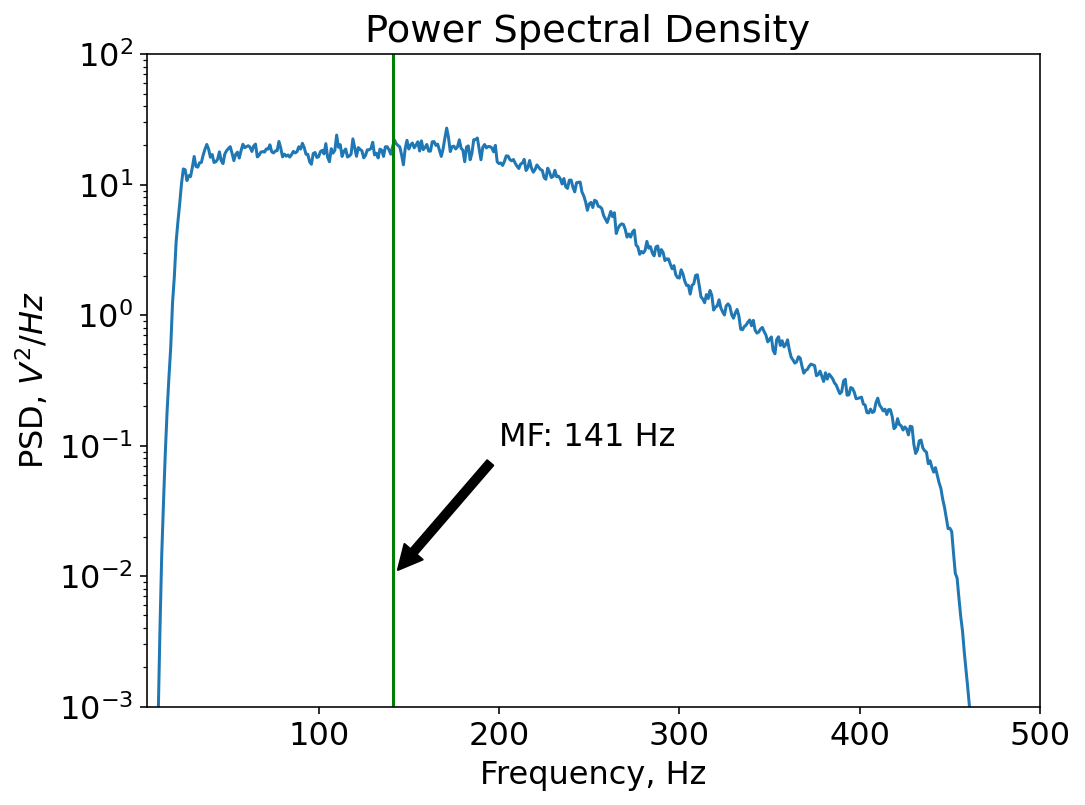

In [69]:
# define window length

win = 1000
f, psd = signal.welch(emg_filtered[19000:75000], sample_rate, nperseg=win)
print(f[:10], psd[:10])

psd_sum = np.sum(psd)
temp = 0.0
index = 0
for i in range(len(f)):
    temp += psd[i]
    if temp >= psd_sum/2:
        index = i
        break
print(f"\nmedia frequency: {f[index]} Hz")

fig, ax = plt.subplots(figsize=(8, 6))
ax.semilogy(f, psd)
ax.set_title("Power Spectral Density ")
ax.set_xlabel("Frequency, Hz")
ax.set_ylabel(r"PSD, $V^2/Hz$")
ax.set_xlim(5, 500)
ax.set_ylim(1e-3, 1e2)
# ax.axvline(20, color='b')
# ax.axvline(450, color='b')
ax.axvline(f[i], color='g')
ax.annotate('MF: 141 Hz', xy=(141, 0.01), xytext=(200, 0.1),
            arrowprops=dict(facecolor='k', shrink=0.05),
            )


**Evaluate the RMS**

以下对1s的窗口计算RMS值，即`window_size = 1000`

Text(0, 0.5, 'Potential difference, $\\mu$V')

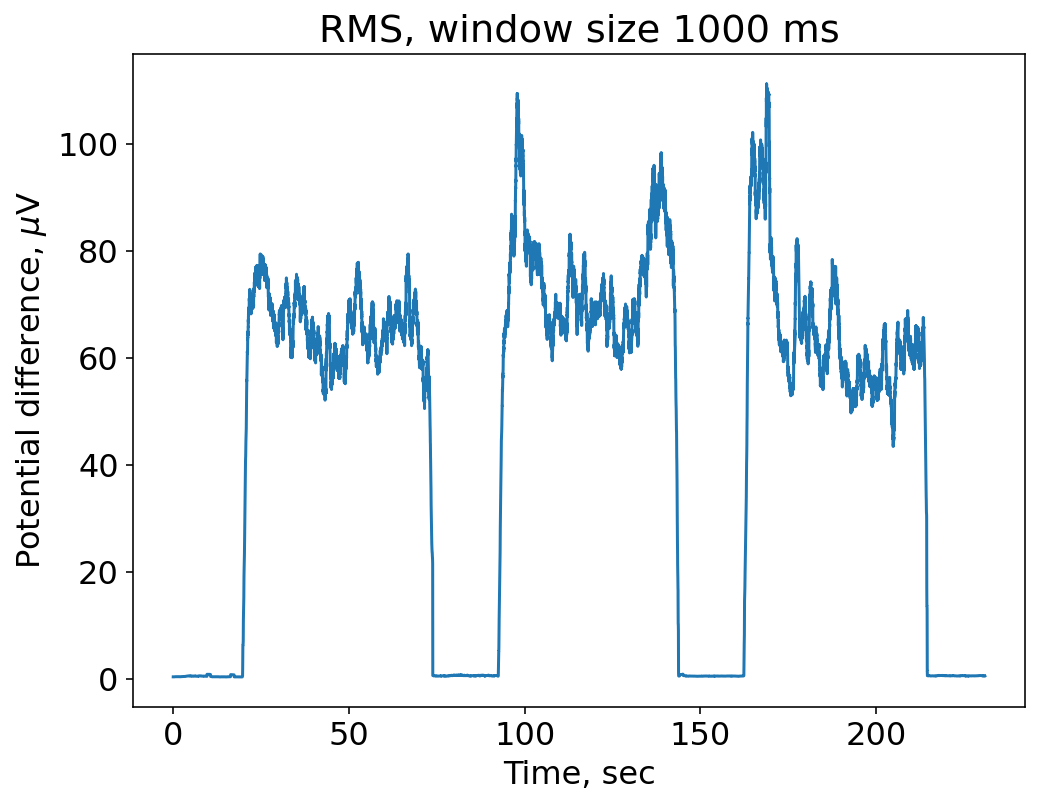

In [70]:
def window_rms(a, window_size):
    a2 = np.power(a, 2)
    window = np.ones(window_size)/float(window_size)
    return np.sqrt(np.convolve(a2, window, 'valid'))

emg_rms = window_rms(emg_filtered, 1000)
t_rms = np.linspace(0, (len(emg_rms)-1)/sample_rate, len(emg_rms))
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t_rms, emg_rms)
ax.set_title("RMS, window size 1000 ms")
ax.set_xlabel('Time, sec')
ax.set_ylabel(r"Potential difference, $\mu$V")
